<a href="https://colab.research.google.com/github/zubaerimran/219_projs/blob/master/code/vae-gan/ssl_chex/ssl_chex_dec10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Semi-Supervised Learning GAN - MNIST dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import time
import os
import pdb

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import tensorlayer as tl
from tensorlayer.layers import *

from matplotlib import pyplot as plt
#%matplotlib inline

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Initialization

In [0]:
x_height, x_width = [128, 128]
num_channels = 1
num_classes = 16
latent_size = 100
labeled_rate = 0.1
g_scale_factor = 1 - 0.75/2
d_scale_factor = 0.25
epsilon = 1e-8 # used to avoid NAN loss

save_to = 'gdrive/My Drive/SSL_GAN/SSL_GAN_VAE/ssl_chex_vae/model_1D/'

if not os.path.exists(save_to):
    os.makedirs(save_to)

log_path = 'gdrive/My Drive/SSL_GAN/SSL_GAN_VAE/ssl_chex_vae/model_1D/ssl_gan_log.csv'
model_path ='gdrive/My Drive/SSL_GAN/SSL_GAN_VAE/ssl_chex_vae/ssl_gan_model.ckpt'

In [0]:
import scipy.io as sio
dataset = sio.loadmat('gdrive/My Drive/SSL_GAN/SSL_GAN_VAE/balanced_chex_70&10.mat')
X_train = dataset['train_image']
X_test = dataset['test_image']
y_train = dataset['train_label']
y_test = dataset['test_label']

In [0]:
import matplotlib.gridspec as gridspec
import cv2

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    
    #samples = samples*127.5 + 127.5
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample[:,:,0])

    return fig

def im_resize(img, des_side):
    # get height and width of image
    height, width = img.shape[:2]
    
    #For rgb to grayscale
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #sqaure image with side equal to height of rectangle
    img_sq = cv2.resize(img,(des_side,des_side),interpolation = cv2.INTER_CUBIC)
    return img_sq

In [0]:
def normalize(x):
    # normalize data
    x = (x - 127.5) / 127.5
    return x.reshape((-1, x_height, x_width, 1))

Build Model

In [0]:
def D(x, dropout_rate, is_training, reuse = True, print_summary = True):
    # discriminator (x -> n + 1 class)

    with tf.variable_scope('Discriminator', reuse = reuse) as scope:
        # layer1 - do not use Batch Normalization on the first layer of Discriminator
        conv1 = tf.layers.conv2d(x, 32, [5, 5],
                                 strides = [2, 2],
                                 padding = 'same')
        lrelu1 = tf.maximum(0.2 * conv1, conv1) #leaky relu
        dropout1 = tf.layers.dropout(lrelu1, dropout_rate)

        # layer2
        conv2 = tf.layers.conv2d(dropout1, 64, [3, 3],
                                 strides = [2, 2],
                                 padding = 'same')
        batch_norm2 = tf.layers.batch_normalization(conv2, training = is_training)
        lrelu2 = tf.maximum(0.2 * batch_norm2, batch_norm2)

        # layer3
        conv3 = tf.layers.conv2d(lrelu2, 128, [2, 2],
                                 strides = [2, 2],
                                 padding = 'same')
        batch_norm3 = tf.layers.batch_normalization(conv3, training = is_training)
        lrelu3 = tf.maximum(0.2 * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(lrelu3, dropout_rate)

        # layer 4
        conv4 = tf.layers.conv2d(dropout3, 128, [2, 2],
                                 strides = [2, 2],
                                 padding = 'same')
        # do not use batch_normalization on this layer - next layer, "flatten5",
        # will be used for "Feature Matching"
        lrelu4 = tf.maximum(0.2 * conv4, conv4)

        # layer 5
        flatten_length = lrelu4.get_shape().as_list()[1] * \
                         lrelu4.get_shape().as_list()[2] * lrelu4.get_shape().as_list()[3]
        flatten5 = tf.reshape(lrelu4, (-1, flatten_length)) # used for "Feature Matching" 
        fc5 = tf.layers.dense(flatten5, (num_classes + 1))
        output = tf.nn.softmax(fc5)

        assert output.get_shape()[1:] == [num_classes + 1]

        if print_summary:
            print('Discriminator summary:\n x: %s\n' \
                  ' D1: %s\n D2: %s\n D3: %s\n D4: %s\n' %(x.get_shape(), 
                                                           dropout1.get_shape(),
                                                           lrelu2.get_shape(), 
                                                           dropout3.get_shape(),
                                                           lrelu4.get_shape()))
        return flatten5, fc5, output

In [0]:

def G(z, is_training, reuse = False, print_summary = False):
    # generator (z -> x)

    with tf.variable_scope('Generator', reuse = reuse) as scope:
        # layer 0
        z_ = tf.layers.dense(z, 512*8*8)
        z_reshaped = tf.reshape(z_, (-1, 8, 8, 512))
        z_dense = tf.nn.relu(z_reshaped)

        # layer 1
        deconv1 = tf.layers.conv2d_transpose(z_dense,
                                             filters = 512,
                                             kernel_size = [3, 3],
                                             strides = [2, 2],
                                             padding = 'same')
        batch_norm1 = tf.layers.batch_normalization(deconv1, training = is_training)
        relu1 = tf.nn.relu(batch_norm1)

        # layer 2
        deconv2 = tf.layers.conv2d_transpose(relu1,
                                             filters = 256,
                                             kernel_size = [3, 3],
                                             strides = [2, 2],
                                             padding = 'same')
        batch_norm2 = tf.layers.batch_normalization(deconv2, training = is_training)
        relu2 = tf.nn.relu(batch_norm2)
        
        
        # layer 3
        deconv3 = tf.layers.conv2d_transpose(relu2,
                                             filters = 128,
                                             kernel_size = [3, 3],
                                             strides = [2, 2],
                                             padding = 'same')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training = is_training)
        relu3 = tf.nn.relu(batch_norm3)

        
        # layer 4
        deconv4 = tf.layers.conv2d_transpose(relu3,
                                             filters = 64,
                                             kernel_size = [3, 3],
                                             strides = [2, 2],
                                             padding = 'same')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training = is_training)
        relu4 = tf.nn.relu(batch_norm4)
        
        # layer 5 - do not use Batch Normalization on the last layer of Generator
        deconv5 = tf.layers.conv2d_transpose(relu4,
                                             filters = num_channels,
                                             kernel_size = [3, 3],
                                             strides = [1, 1],
                                             padding = 'same')
        tanh5 = tf.tanh(deconv5)
        
        print(tanh5.shape)
                                             
                                             
        assert tanh5.get_shape()[1:] == [x_height, x_width, num_channels]
        
        if print_summary:
            print('Generator summary:\n z: %s\n' \
                  ' G0: %s\n G1: %s\n G2: %s\n G3: %s\n G4: %s\n G5: %s\n' %(z_.get_shape(),
                                                                    z_reshaped.get_shape(),
                                                                    relu1.get_shape(),
                                                                    relu2.get_shape(),
                                                                    relu3.get_shape(),
                                                                    relu4.get_shape(),
                                                                    tanh5.get_shape()))
        return tanh5

In [0]:
def encoder(input_imgs_, is_train = True, reuse = False):
        '''
        input_imgs: the input images to be encoded into a vector as latent representation. size here is [b_size,64,64,3]
        
        '''
        z_dim = latent_size # 512
        ef_dim = 64 # encoder filter number

        w_init = tf.random_normal_initializer(stddev=0.02)
        gamma_init = tf.random_normal_initializer(1., 0.02)
        
        input_imgs = tf.reshape(input_imgs_,[-1, 128, 128,1])
        with tf.variable_scope("Encoder", reuse = reuse):
            tl.layers.set_name_reuse(reuse)

            net_in = InputLayer(input_imgs, name='en/in') # (b_size,64,64,3)
            net_h0 = Conv2d(net_in, ef_dim, (5, 5), (2, 2), act=None,
                    padding='SAME', W_init=w_init, name='en/h0/conv2d')
            net_h0 = BatchNormLayer(net_h0, act=tf.nn.relu,
                    is_train=is_train, gamma_init=gamma_init, name='en/h0/batch_norm')
            # net_h0.outputs._shape = (b_size,32,32,64)

            net_h1 = Conv2d(net_h0, ef_dim*2, (5, 5), (2, 2), act=None,
                    padding='SAME', W_init=w_init, name='en/h1/conv2d')
            net_h1 = BatchNormLayer(net_h1, act=tf.nn.relu,
                    is_train=is_train, gamma_init=gamma_init, name='en/h1/batch_norm')
            # net_h1.outputs._shape = (b_size,16,16,64*2)

            net_h2 = Conv2d(net_h1, ef_dim*4, (5, 5), (2, 2), act=None,
                    padding='SAME', W_init=w_init, name='en/h2/conv2d')
            net_h2 = BatchNormLayer(net_h2, act=tf.nn.relu,
                    is_train=is_train, gamma_init=gamma_init, name='en/h2/batch_norm')
            # net_h2.outputs._shape = (b_size,8,8,64*4)

            net_h3 = Conv2d(net_h2, ef_dim*8, (5, 5), (2, 2), act=None,
                    padding='SAME', W_init=w_init, name='en/h3/conv2d')
            net_h3 = BatchNormLayer(net_h3, act=tf.nn.relu,
                    is_train=is_train, gamma_init=gamma_init, name='en/h3/batch_norm')
            # net_h2.outputs._shape = (b_size,4,4,64*8)

            # mean of z
            net_h4 = FlattenLayer(net_h3, name='en/h4/flatten')
            # net_h4.outputs._shape = (b_size,8*8*64*4)
            net_out1 = DenseLayer(net_h4, n_units=z_dim, act=tf.identity,
                    W_init = w_init, name='en/h3/lin_sigmoid')
            net_out1 = BatchNormLayer(net_out1, act=tf.identity,
                    is_train=is_train, gamma_init=gamma_init, name='en/out1/batch_norm')

            # net_out1 = DenseLayer(net_h4, n_units=z_dim, act=tf.nn.relu,
            #         W_init = w_init, name='en/h4/lin_sigmoid')
            z_mean = net_out1.outputs # (b_size,512)

            # log of variance of z(covariance matrix is diagonal)
            net_h5 = FlattenLayer(net_h3, name='en/h5/flatten')
            net_out2 = DenseLayer(net_h5, n_units=z_dim, act=tf.identity,
                    W_init = w_init, name='en/h4/lin_sigmoid')
            net_out2 = BatchNormLayer(net_out2, act=tf.nn.softplus,
                    is_train=is_train, gamma_init=gamma_init, name='en/out2/batch_norm')
            # net_out2 = DenseLayer(net_h5, n_units=z_dim, act=tf.nn.relu,
            #         W_init = w_init, name='en/h5/lin_sigmoid')
            z_log_sigma_sq = net_out2.outputs + 1e-6# (b_size,512)
            
            #pdb.set_trace()
            return net_out1, net_out2, z_mean, z_log_sigma_sq
          

In [0]:
def build_model(x_real, z, label, dropout_rate, is_training, print_summary = False):
    # build model
    # Real image input -> D
    D_real_features, D_real_logit, D_real_prob = D(x_real, dropout_rate, is_training,
                                                   reuse = False, print_summary = print_summary)
    
    
    #Encode real image input -> Encoder
    _,_,z_mu,z_log_sigma_sq = encoder(x_real) #
    eps = tf.random_normal(shape=tf.shape(z_log_sigma_sq), #
                               mean=0, stddev=1, dtype=tf.float32) #
    z_x_real = z_mu + tf.sqrt(tf.exp(z_log_sigma_sq)) * eps #
    #Reconstructed real images
    x_real_tilde = G(z_x_real, is_training, reuse = False, print_summary = print_summary) #
    #Reconstructed real image input -> D
    D_real_tilde_features, D_real_tilde_logit, D_real_tilde_prob = D(x_real_tilde, dropout_rate, is_training, reuse = True, print_summary = print_summary)
    
    x_hat = tf.reshape(x_real_tilde,[-1,784]) #
    
    #Generate fake images from Random Noise
    x_fake = G(z, is_training, reuse = True, print_summary = print_summary)
    #Fake images input -> D
    D_fake_features, D_fake_logit, D_fake_prob = D(x_fake, dropout_rate, is_training,
                                                   reuse = True, print_summary = print_summary)

    return D_real_features, D_real_logit, D_real_prob, \
           D_real_tilde_features, D_real_tilde_logit, D_real_tilde_prob, \
           D_fake_features, D_fake_logit, D_fake_prob,  \
           x_fake, z_mu, z_log_sigma_sq, x_hat #

In [0]:
def prepare_labels(label):
    # add extra label for fake data
    extended_label = tf.concat([label, tf.zeros([tf.shape(label)[0], 1])], axis = 1)

    return extended_label

In [0]:
def NLLNormal(pred, target):

    c = -0.5 * tf.log(2 * np.pi)
    multiplier = 1.0 / (2.0 * 1)
    tmp_ = tf.square(pred - target)
    tmp_ *= -multiplier
    tmp_ += c

    return tmp_

In [0]:
def loss_accuracy(x, batch_size, D_real_features, D_real_logit, D_real_prob,
                  D_real_tilde_features, D_real_tilde_logit, D_real_tilde_prob,
                  D_fake_features, D_fake_logit, D_fake_prob, extended_label, labeled_mask, z_mu, z_log_sigma_sq): #
    
    # *** Encoder loss ***
    #KL loss for encoder
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mu) - tf.exp(z_log_sigma_sq), axis=1)
    # preceptual loss(feature loss)
    #pdb.set_trace()
    LL_loss = tf.reduce_mean(tf.reduce_sum(NLLNormal(D_real_tilde_features, D_real_features)))
   
    #For encode
    E_loss = kl_loss/(latent_size*batch_size) - LL_loss / (4 * 4 * 256) 
    E_loss = tf.reduce_mean(E_loss)

#     epsilon = 1e-10
#     tmp = tf.clip_by_value(epsilon + x_hat,epsilon, 1)
#     tmp_ = tf.clip_by_value(epsilon+1-x_hat,epsilon, 1)
#     recon_loss = -tf.reduce_sum(
#             x * tf.log(tmp) + (1-x) * tf.log(tmp_), 
#             axis=1
#         )
#     recon_loss = tf.reduce_mean(recon_loss)
#     # Latent loss
#     # Kullback Leibler divergence: measure the difference between two distributions
#     # Here we measure the divergence between the latent distribution and N(0, 1)
#     latent_loss = -0.5 * tf.reduce_sum(
#         1 + z_log_sigma_sq - tf.square(z_mu) - tf.exp(z_log_sigma_sq), axis=1)
#     latent_loss = tf.reduce_mean(latent_loss)

#     x_hat_reshaped = tf.reshape(x_hat, [-1, 28, 28])
#     tv_loss = tf.reduce_mean(tf.image.total_variation(x_hat_reshaped))
#     total_loss = tf.reduce_mean(recon_loss + latent_loss + tv_loss)
    

    # *** Generator loss ***
    '''
    G_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                                 (labels=tf.ones_like(D_fake_logit)- g_scale_factor, logits=D_fake_prob)) #changed
    G_tilde_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
              (labels=tf.ones_like(D_real_tilde_logit) - g_scale_factor, logits=D_real_tilde_logit))
    G_loss = G_fake_loss + G_tilde_loss - 1e-6*LL_loss
    '''
    # fake data is mistaken to be real
    prob_fake_be_real = 1 - D_fake_prob[:, -1] + epsilon
    tmp_log =  tf.log(prob_fake_be_real)
    G_L1 = -1 * tf.reduce_mean(tmp_log)

    # Feature Maching with real
    tmp1 = tf.reduce_mean(D_real_features, axis = 0)
    tmp2 = tf.reduce_mean(D_fake_features, axis = 0)
    G_L2 = tf.reduce_mean(tf.square(tmp1 - tmp2))
    
    # Feature Maching with tilde
    tmp1 = tf.reduce_mean(D_real_tilde_features, axis = 0)
    tmp2 = tf.reduce_mean(D_fake_features, axis = 0)
    G_L3 = tf.reduce_mean(tf.square(tmp1 - tmp2))
    
    G_loss = G_L1 + G_L2 + G_L3 - 1e-6*LL_loss 

#     # fake data is mistaken to be real
#     prob_fake_be_real = 1 - D_fake_prob[:, -1] + epsilon
#     tmp_log =  tf.log(prob_fake_be_real)
#     G_L1 = -1 * tf.reduce_mean(tmp_log)

#     # Feature Maching
#     tmp1 = tf.reduce_mean(D_real_features, axis = 0)
#     tmp2 = tf.reduce_mean(D_fake_features, axis = 0)
#     G_L2 = tf.reduce_mean(tf.square(tmp1 - tmp2))

#     G_L = G_L1 + G_L2
    
  # *** Discriminator loss ***
    # supervised loss
    # which class the real data belongs to
    tmp = tf.nn.softmax_cross_entropy_with_logits(logits = D_real_logit,
                                                  labels = extended_label)
    D_supervised_loss = tf.reduce_sum(labeled_mask * tmp) / tf.reduce_sum(labeled_mask) # to ignore
                                                                                     # unlabeled
                                                                                     # data

    # unsupervised loss
    
    '''
    D_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(D_fake_logit), logits=D_fake_logit))
    D_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_real_logit) - d_scale_factor, logits=D_real_logit))
    D_tilde_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(D_real_tilde_logit), logits=D_real_tilde_logit))
    '''
    # data is real
    prob_real_be_real = 1 - D_real_prob[:, -1] + epsilon
    tmp_log = tf.log(prob_real_be_real)
    D_real_loss = -1 * tf.reduce_mean(tmp_log)

    # data is fake
    prob_fake_be_fake = D_fake_prob[:, -1] + epsilon
    tmp_log = tf.log(prob_fake_be_fake)
    D_fake_loss = -1 * tf.reduce_mean(tmp_log)

    #data is tilde
    prob_tilde_be_tilde = D_real_tilde_prob[:, -1] + epsilon
    tmp_log = tf.log(prob_tilde_be_tilde)
    D_tilde_loss = -1 * tf.reduce_mean(tmp_log)


    
    #   D_L = D_L_supervised + D_L_unsupervised1 + D_L_unsupervised2
    
    
    D_loss = D_fake_loss + D_real_loss + D_tilde_loss + D_supervised_loss

#     # data is real
#     prob_real_be_real = 1 - D_real_prob[:, -1] + epsilon
#     tmp_log = tf.log(prob_real_be_real)
#     D_L_unsupervised1 = -1 * tf.reduce_mean(tmp_log)

#     # data is fake
#     prob_fake_be_fake = D_fake_prob[:, -1] + epsilon
#     tmp_log = tf.log(prob_fake_be_fake)
#     D_L_unsupervised2 = -1 * tf.reduce_mean(tmp_log)

 #   D_L = D_L_supervised + D_L_unsupervised1 + D_L_unsupervised2
    

    # accuracy
    correct_prediction = tf.equal(tf.argmax(D_real_prob[:, :-1], 1),
                                  tf.argmax(extended_label[:, :-1], 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return D_loss, G_loss, E_loss, accuracy 

In [0]:
def optimizer(D_Loss, G_Loss, E_Loss, G_learning_rate, D_learning_rate, E_learning_rate): 
  #D_L, G_L, E_L, G_learning_rate, D_learning_rate, E_learning_rate
    # D and G optimizer
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        all_vars = tf.trainable_variables()
        D_vars = [var for var in all_vars if var.name.startswith('Discriminator')]
        G_vars = [var for var in all_vars if var.name.startswith('Generator')]
        E_vars = [var for var in all_vars if var.name.startswith('Encoder')]

        D_optimizer = tf.train.AdamOptimizer(D_learning_rate).minimize(D_Loss, var_list = D_vars)
        G_optimizer = tf.train.AdamOptimizer(G_learning_rate).minimize(G_Loss, var_list = G_vars)
        E_optimizer = tf.train.AdamOptimizer(E_learning_rate).minimize(E_Loss, var_list = E_vars)
        return D_optimizer, G_optimizer, E_optimizer

Visualize

In [0]:
def plot_fake_data(data, grid_size = [5, 5]):
    # visualize some data generated by G
    _, axes = plt.subplots(figsize = grid_size, nrows = grid_size[0], ncols = grid_size[1],
                           sharey = True, sharex = True)

    size = grid_size[0] * grid_size[1]
    index = np.int_(np.random.uniform(0, data.shape[0], size = (size)))
    figs = data[index].reshape(-1, x_height, x_width)

    for idx, ax in enumerate(axes.flatten()):
        ax.axis('off')
        ax.imshow(figs[idx], cmap = 'gray')
    plt.tight_layout()
    plt.show()

Train Model

In [0]:
def save_model_on_imporvemnet(file_path, sess, cv_acc, cv_accs):
  #  # save model when there is improvemnet in cv_acc value
    if cv_accs == [] or cv_acc > np.max(cv_accs):
        saver = tf.train.Saver(max_to_keep = 1)
        saver.save(sess, file_path)
        print('Model saved')
    print('')

In [0]:
def get_labled_mask(labeled_rate, batch_size):
    # get labeled mask to mask some data unlabeled
    labeled_mask = np.zeros([batch_size], dtype = np.float32)
    labeled_count = np.int(batch_size * labeled_rate)
    labeled_mask[range(labeled_count)] = 1.0
    #np.random.shuffle(labeled_mask)

    return labeled_mask

In [0]:
def log_loss_acc(file_path, epoch, train_loss_D, train_loss_G, train_loss_E, train_Acc,
                 cv_loss_D, cv_loss_G, cv_loss_E, cv_Acc, log_mode = 'a'):
    # log train and cv losses as well as accuracy
    mode = log_mode if epoch == 0 else 'a'

    with open(file_path, mode) as f:
        if mode == 'w':
            header = 'epoch, train_loss_D, train_loss_G, train_loss_E, train_Acc,' \
                     'cv_loss_D, cv_loss_G, cv_loss_E, cv_Acc\n'
            f.write(header)

        line = '%d, %f, %f, %f, %f, %f, %f, %f, %f\n' %(epoch, train_loss_D, train_loss_G, train_loss_E, train_Acc,
                                                cv_loss_D, cv_loss_G, cv_loss_E, cv_Acc)
        f.write(line)

In [0]:
def train_SSL_GAN(batch_size, epochs):
    # train Semi-Supervised Learning GAN
    train_D_losses, train_G_losses, train_E_losses, train_Accs = [], [], [], []
    cv_D_losses, cv_G_losses, cv_E_losses, cv_Accs = [], [], [], []

    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, name = 'x', shape = [None, x_height, x_width, num_channels])
    label = tf.placeholder(tf.float32, name = 'label', shape = [None, num_classes])
    labeled_mask = tf.placeholder(tf.float32, name = 'labeled_mask', shape = [None])
    z = tf.placeholder(tf.float32, name = 'z', shape = [None, latent_size])
    dropout_rate = tf.placeholder(tf.float32, name = 'dropout_rate')
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    G_learning_rate = tf.placeholder(tf.float32, name = 'G_learning_rate')
    D_learning_rate = tf.placeholder(tf.float32, name = 'D_learning_rate')
    E_learning_rate = tf.placeholder(tf.float32, name = 'E_learning_rate')

    model = build_model(x, z, label, dropout_rate, is_training, print_summary = True)
    
    
    D_real_features, D_real_logit, D_real_prob, \
    D_real_tilde_features, D_real_tilde_logit, D_real_tilde_prob,\
    D_fake_features, D_fake_logit, D_fake_prob, \
    fake_data, z_mu, z_log_sigma_sq, x_hat = model #
    
    extended_label = prepare_labels(label)
        
    loss_acc  = loss_accuracy(x, batch_size, D_real_features, D_real_logit, D_real_prob,
                              D_real_tilde_features, D_real_tilde_logit, D_real_tilde_prob,
                              D_fake_features, D_fake_logit, D_fake_prob,
                              extended_label, labeled_mask,
                              z_mu, z_log_sigma_sq) #
    D_L, G_L, E_L, accuracy = loss_acc # D_loss, G_loss, E_loss, accuracy 
    D_optimizer, G_optimizer, E_optimizer = optimizer(D_L, G_L, E_L, G_learning_rate, D_learning_rate, E_learning_rate) 

    print('training....')

    with tf.Session() as sess:       
        sess.run(tf.global_variables_initializer())
      

        for epoch in range(epochs):
            t_total = 0
            for iter in range(int(X_train.shape[0] / batch_size) + 1):
                t_start = time.time()
                
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                batch_images = X_train[idx]
                batch_labels = y_train[idx]
                
                batch_z = np.random.uniform(-1.0, 1.0, size = (batch_size, latent_size))
                mask = get_labled_mask(labeled_rate, batch_size)
                
                train_feed_dictionary = {x:  normalize(batch_images),
                                         z: batch_z,
                                         label: batch_labels,
                                         labeled_mask: mask,
                                         dropout_rate: 0.5,
                                         G_learning_rate: 1e-5,
                                         D_learning_rate: 1e-5,
                                         E_learning_rate: 1e-5,
                                         is_training: True}

                D_optimizer.run(feed_dict = train_feed_dictionary)
                G_optimizer.run(feed_dict = train_feed_dictionary)
                E_optimizer.run(feed_dict = train_feed_dictionary)

                train_D_loss = D_L.eval(feed_dict = train_feed_dictionary)
                train_G_loss = G_L.eval(feed_dict = train_feed_dictionary)
                train_E_loss = E_L.eval(feed_dict = train_feed_dictionary)
                train_accuracy = accuracy.eval(feed_dict = train_feed_dictionary)
                t_total += (time.time() - t_start)
                
                #pdb.set_trace()
            print('epoch: ', epoch, 'time: ',t_total, 'train_G_Loss: ',train_G_loss, 'train_D_Loss: ', 
                  train_D_loss, 'train_E_Loss: ', train_E_loss, 'train_acc: ', train_accuracy)
                      #(epoch, t_total, train_G_loss, train_D_loss, train_E_loss, train_accuracy))
                #print(epoch, train_accuracy)
            train_D_losses.append(train_D_loss)
            train_G_losses.append(train_G_loss)
            train_E_losses.append(train_E_loss)
            train_Accs.append(train_accuracy)

            # Cross-Validation
            cv_size = y_test.shape[0]
            cv_batch_z = np.random.uniform(-1.0, 1.0, size = (cv_size, latent_size))
            mask = get_labled_mask(1, cv_size)
            cv_feed_dictionary = {x: normalize(X_test),
                                  z: cv_batch_z,
                                  label: y_test,
                                  labeled_mask: mask,
                                  dropout_rate: 0.0,
                                  is_training: False}

            cv_D_loss = D_L.eval(feed_dict = cv_feed_dictionary)
            cv_G_loss = G_L.eval(feed_dict = cv_feed_dictionary)
            cv_E_loss = E_L.eval(feed_dict = cv_feed_dictionary)
            cv_accuracy = accuracy.eval(feed_dict = cv_feed_dictionary)
            
#             recon_loss_ = recon_loss.
#             latent_loss_ = latent_loss.
#             tv_loss_ - tv_loss

            log_loss_acc(log_path, epoch, train_D_loss, train_G_loss, train_E_loss, train_accuracy,
                         cv_D_loss, cv_G_loss, cv_E_loss, cv_accuracy, log_mode = 'w')
            print('\ncv_G_Loss: %f, cv_D_loss: %f, cv_E_loss: %f, cv_acc: %f' %(cv_G_loss,
                                                                 cv_D_loss,
                                                                 cv_E_loss,
                                                                 cv_accuracy
                                                                 ))
            save_model_on_imporvemnet(model_path, sess, cv_accuracy, cv_Accs)
            cv_D_losses.append(cv_D_loss)
            cv_G_losses.append(cv_G_loss)
            cv_E_losses.append(cv_E_loss)
            cv_Accs.append(cv_accuracy)

            if epoch % 10 == 0:
                fakes = fake_data.eval(feed_dict = cv_feed_dictionary)
                #print(fakes.shape) #checking the shape of the fake images
                plot_fake_data(fakes, [5, 5])
                fig = plot(fakes[:16])
                plt.savefig((save_to + 'G@epoch{}.png').format(str(epoch).zfill(3)), bbox_inches = "tight")
                plt.close()

    return train_D_losses, train_G_losses, train_E_losses, train_Accs, cv_D_losses, cv_G_losses, cv_E_losses, cv_Accs

Discriminator summary:
 x: (?, 128, 128, 1)
 D1: (?, 64, 64, 32)
 D2: (?, 32, 32, 64)
 D3: (?, 16, 16, 128)
 D4: (?, 8, 8, 128)

[TL] WARNING: this method is DEPRECATED and has no effect, please remove it from your code.
[TL] InputLayer  Encoder/en/in: (?, 128, 128, 1)
[TL] Conv2d Encoder/en/h0/conv2d: n_filter: 64 filter_size: (5, 5) strides: (2, 2) pad: SAME act: No Activation
[TL] BatchNormLayer Encoder/en/h0/batch_norm: decay: 0.900000 epsilon: 0.000010 act: relu is_train: True
[TL] Conv2d Encoder/en/h1/conv2d: n_filter: 128 filter_size: (5, 5) strides: (2, 2) pad: SAME act: No Activation
[TL] BatchNormLayer Encoder/en/h1/batch_norm: decay: 0.900000 epsilon: 0.000010 act: relu is_train: True
[TL] Conv2d Encoder/en/h2/conv2d: n_filter: 256 filter_size: (5, 5) strides: (2, 2) pad: SAME act: No Activation
[TL] BatchNormLayer Encoder/en/h2/batch_norm: decay: 0.900000 epsilon: 0.000010 act: relu is_train: True
[TL] Conv2d Encoder/en/h3/conv2d: n_filter: 512 filter_size: (5, 5) strides: 

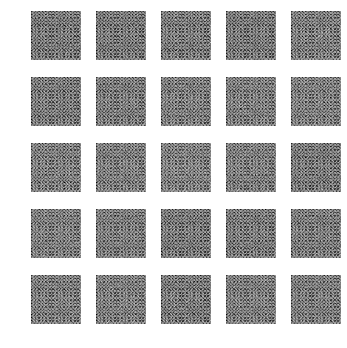

epoch:  1 time:  57.36472773551941 train_G_Loss:  0.38884133 train_D_Loss:  11.051567 train_E_Loss:  68.96263 train_acc:  0.125

cv_G_Loss: 1.559936, cv_D_loss: 8.984485, cv_E_loss: 328.129761, cv_acc: 0.087500
Model saved

epoch:  2 time:  57.33816385269165 train_G_Loss:  0.39206538 train_D_Loss:  10.656897 train_E_Loss:  68.61869 train_acc:  0.09375

cv_G_Loss: 1.864636, cv_D_loss: 8.817167, cv_E_loss: 362.910461, cv_acc: 0.087500

epoch:  3 time:  57.350809812545776 train_G_Loss:  0.4004739 train_D_Loss:  10.313384 train_E_Loss:  68.5782 train_acc:  0.0

cv_G_Loss: 2.029382, cv_D_loss: 8.178431, cv_E_loss: 376.569427, cv_acc: 0.062500

epoch:  4 time:  57.32067799568176 train_G_Loss:  0.41583848 train_D_Loss:  9.730149 train_E_Loss:  68.59795 train_acc:  0.03125

cv_G_Loss: 2.163574, cv_D_loss: 7.929486, cv_E_loss: 379.901855, cv_acc: 0.056250

epoch:  5 time:  57.35814547538757 train_G_Loss:  0.42650196 train_D_Loss:  9.663476 train_E_Loss:  68.81142 train_acc:  0.0

cv_G_Loss: 2.3

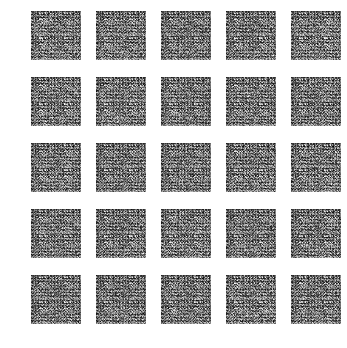

epoch:  11 time:  57.43225383758545 train_G_Loss:  0.41104603 train_D_Loss:  7.856201 train_E_Loss:  69.446304 train_acc:  0.0625

cv_G_Loss: 4.475461, cv_D_loss: 6.904163, cv_E_loss: 394.380951, cv_acc: 0.087500

epoch:  12 time:  57.45599055290222 train_G_Loss:  0.3996833 train_D_Loss:  8.087132 train_E_Loss:  69.314545 train_acc:  0.125

cv_G_Loss: 4.980334, cv_D_loss: 7.004129, cv_E_loss: 398.292816, cv_acc: 0.093750

epoch:  13 time:  57.394623041152954 train_G_Loss:  0.39672574 train_D_Loss:  9.1740265 train_E_Loss:  68.92998 train_acc:  0.15625

cv_G_Loss: 5.459659, cv_D_loss: 7.196375, cv_E_loss: 400.938873, cv_acc: 0.100000
Model saved

epoch:  14 time:  57.36982560157776 train_G_Loss:  0.40948623 train_D_Loss:  7.983697 train_E_Loss:  68.81819 train_acc:  0.125

cv_G_Loss: 5.868835, cv_D_loss: 7.595837, cv_E_loss: 400.676758, cv_acc: 0.100000

epoch:  15 time:  57.381253719329834 train_G_Loss:  0.4076997 train_D_Loss:  8.12663 train_E_Loss:  68.78171 train_acc:  0.125

cv_G_L

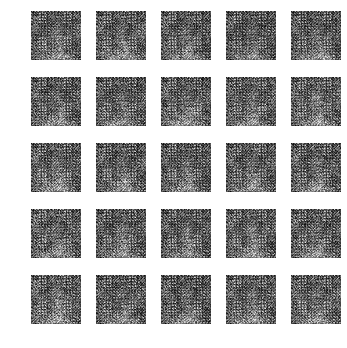

epoch:  21 time:  57.34882164001465 train_G_Loss:  0.38755572 train_D_Loss:  9.198139 train_E_Loss:  67.948074 train_acc:  0.0625

cv_G_Loss: 6.867628, cv_D_loss: 12.378144, cv_E_loss: 368.820953, cv_acc: 0.087500

epoch:  22 time:  57.40896248817444 train_G_Loss:  0.38330677 train_D_Loss:  9.120233 train_E_Loss:  67.75968 train_acc:  0.09375

cv_G_Loss: 6.802916, cv_D_loss: 12.724716, cv_E_loss: 366.942841, cv_acc: 0.087500

epoch:  23 time:  57.367323875427246 train_G_Loss:  0.39502203 train_D_Loss:  8.846217 train_E_Loss:  67.77211 train_acc:  0.0625

cv_G_Loss: 6.468683, cv_D_loss: 13.412383, cv_E_loss: 367.110809, cv_acc: 0.093750

epoch:  24 time:  57.36213278770447 train_G_Loss:  0.38881794 train_D_Loss:  9.113277 train_E_Loss:  67.53753 train_acc:  0.125

cv_G_Loss: 6.365925, cv_D_loss: 14.258980, cv_E_loss: 367.141663, cv_acc: 0.081250

epoch:  25 time:  57.37311673164368 train_G_Loss:  0.3964024 train_D_Loss:  10.226948 train_E_Loss:  67.466675 train_acc:  0.09375

cv_G_Loss:

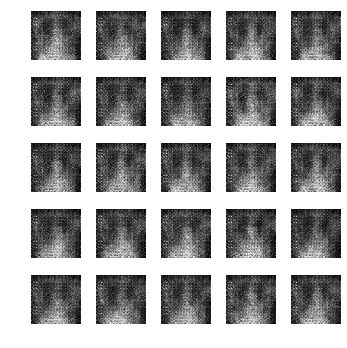

epoch:  31 time:  57.366013288497925 train_G_Loss:  0.3622654 train_D_Loss:  10.49523 train_E_Loss:  65.35074 train_acc:  0.21875

cv_G_Loss: 4.736591, cv_D_loss: 8.793845, cv_E_loss: 353.319153, cv_acc: 0.081250

epoch:  32 time:  57.37203621864319 train_G_Loss:  0.3647948 train_D_Loss:  11.779811 train_E_Loss:  64.79097 train_acc:  0.28125

cv_G_Loss: 4.220154, cv_D_loss: 9.387637, cv_E_loss: 349.283386, cv_acc: 0.087500

epoch:  33 time:  57.3936870098114 train_G_Loss:  0.36517897 train_D_Loss:  9.12981 train_E_Loss:  64.3748 train_acc:  0.09375

cv_G_Loss: 3.664482, cv_D_loss: 9.280422, cv_E_loss: 346.626526, cv_acc: 0.106250

epoch:  34 time:  57.37421751022339 train_G_Loss:  0.36880106 train_D_Loss:  9.177058 train_E_Loss:  64.25539 train_acc:  0.15625

cv_G_Loss: 3.363746, cv_D_loss: 9.334003, cv_E_loss: 344.322693, cv_acc: 0.112500
Model saved

epoch:  35 time:  57.43155646324158 train_G_Loss:  0.377491 train_D_Loss:  10.188979 train_E_Loss:  64.2131 train_acc:  0.03125

cv_G_L

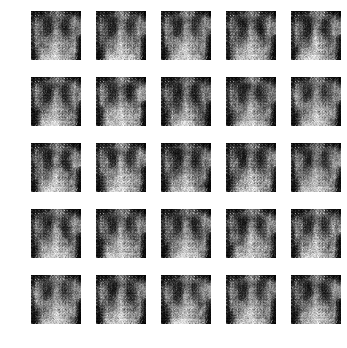

epoch:  41 time:  57.53268337249756 train_G_Loss:  0.41445756 train_D_Loss:  7.9508476 train_E_Loss:  64.33531 train_acc:  0.15625

cv_G_Loss: 2.464474, cv_D_loss: 9.216080, cv_E_loss: 333.045715, cv_acc: 0.087500

epoch:  42 time:  57.362703800201416 train_G_Loss:  0.39393505 train_D_Loss:  10.497775 train_E_Loss:  63.574795 train_acc:  0.09375

cv_G_Loss: 2.831583, cv_D_loss: 8.928865, cv_E_loss: 332.492920, cv_acc: 0.100000

epoch:  43 time:  57.43403100967407 train_G_Loss:  0.4090714 train_D_Loss:  9.095903 train_E_Loss:  63.68119 train_acc:  0.15625

cv_G_Loss: 2.860733, cv_D_loss: 9.313266, cv_E_loss: 331.138123, cv_acc: 0.087500

epoch:  44 time:  57.38199210166931 train_G_Loss:  0.41185433 train_D_Loss:  9.282742 train_E_Loss:  64.15749 train_acc:  0.125

cv_G_Loss: 3.102054, cv_D_loss: 9.221354, cv_E_loss: 331.432922, cv_acc: 0.087500

epoch:  45 time:  57.41599798202515 train_G_Loss:  0.4181475 train_D_Loss:  9.333703 train_E_Loss:  63.80693 train_acc:  0.0

cv_G_Loss: 3.1728

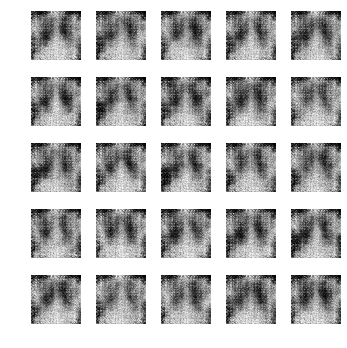

epoch:  51 time:  57.39793610572815 train_G_Loss:  0.4820153 train_D_Loss:  9.950178 train_E_Loss:  63.724197 train_acc:  0.21875

cv_G_Loss: 4.210217, cv_D_loss: 8.605218, cv_E_loss: 331.444153, cv_acc: 0.081250

epoch:  52 time:  57.3823618888855 train_G_Loss:  0.46573472 train_D_Loss:  9.842469 train_E_Loss:  64.04009 train_acc:  0.15625

cv_G_Loss: 4.061387, cv_D_loss: 8.648847, cv_E_loss: 331.755280, cv_acc: 0.068750

epoch:  53 time:  57.454384565353394 train_G_Loss:  0.4971808 train_D_Loss:  8.518065 train_E_Loss:  64.51671 train_acc:  0.125

cv_G_Loss: 4.063987, cv_D_loss: 8.611113, cv_E_loss: 332.345947, cv_acc: 0.087500

epoch:  54 time:  57.34001588821411 train_G_Loss:  0.49254543 train_D_Loss:  10.409147 train_E_Loss:  64.571434 train_acc:  0.15625

cv_G_Loss: 3.904012, cv_D_loss: 8.787038, cv_E_loss: 333.860840, cv_acc: 0.075000

epoch:  55 time:  57.455384731292725 train_G_Loss:  0.526106 train_D_Loss:  9.016378 train_E_Loss:  64.86273 train_acc:  0.1875

cv_G_Loss: 3.938

In [0]:
loss_acc = train_SSL_GAN(32, 300)